First, we will import all the libraries including the  twoPlanetTTV function from NbodyTTV.py that we created and that was demonstrated in the first notebook. This function utilizes numba JIT which is perfect for running MCMC if you don't want to waste time computing your model at each step.



In [3]:
# Importing all required packages (costume script is included in the same directory)
from NbodyTTV import twoPlanetTTV
import corner
import batman as bm
import numpy as np
from matplotlib import pyplot as plt
import time
import matplotlib as mpl
from tqdm import trange

In [4]:
mpl.rcParams['figure.dpi'] = 300

In [7]:
# Setting up random seeds
np.random.seed(42)

# Preliminary assumptions / expectations of some parameters
global Ms # host star mass
Ms = 1

global Mp1 # ratio between two planets in our system
Mp1 = 1

global Tp1 # transit period in days
Tp1 = 10

As discussed in the PDF file, we will be fixing some of the parameters and using the mass ratio of 2 planets as the estimation for the mass of the second planet. We define our model function which will take these parameters, run a quick N-body simulation and output the O-C curve.


In [11]:
# Defining a function for getting the OC curve
def get_oc(pars, ts):
    pars = np.array(pars, dtype=float)

    m0 = Ms
    m1 = Mp1
    m2 = Mp1 / pars[0]
    T1 = Tp1
    T2 = pars[1]
    e1 = 0
    e2 = pars[2]
    w1 = 0
    w2 = pars[3]

    ts = twoPlanetTTV(m0, m1, m2,
                      T1, T2, e1, e2, w1, w2, Ntransits=ts)

    periods = np.diff(ts)

    expected = [ts[0] + np.mean(periods) * n for n in range(len(ts))]

    OC = ts - expected

    return OC*24*60

In [13]:
# Defining function for getting the chi2 value back
def chisq(pars, data, ts, Ninv):

    if pars[2] < 0:
        return np.inf

    y = get_oc(pars, ts)
    r = data-y
    chisq = r@Ninv@r
    return chisq

In [15]:
# This cell shows the main body and process of the MCMC chain
def run_chain(pars, fun, data, ts, Ninv, L, nsamp=100, adapt_steps=110, target_acceptance=0.28):
    chisq = np.zeros(nsamp)
    npar = len(pars)
    chain = np.zeros([nsamp, npar])
    chain[0, :] = pars
    chisq[0] = fun(pars, data, ts, Ninv)
    acceptance_count = 0  # Track acceptance count
    step_size = L  # Initialize step size

    for i in trange(1, nsamp):
        pnew = chain[i - 1, :] + step_size * np.random.randn(npar)
        chi_new = fun(pnew, data, ts, Ninv)
        prob = np.exp(0.5 * (chisq[i - 1] - chi_new))

        if np.random.rand(1)[0] < prob:  # Accept step
            chain[i, :] = pnew
            chisq[i] = chi_new
            acceptance_count += 1
        else:  # Reject step
            chain[i, :] = chain[i - 1, :]
            chisq[i] = chisq[i - 1]

        # Adjust step size every `adapt_steps` iterations
        if i % adapt_steps == 0:
            acceptance_rate = acceptance_count / adapt_steps
            # print(acceptance_rate)
            if acceptance_rate < target_acceptance:
                step_size *= 0.8  # Decrease step size
            elif acceptance_rate > target_acceptance:
                step_size *= 1.2  # Increase step size
            acceptance_count = 0  # Reset acceptance count

    return chain, chisq

In [17]:
# Initializing the OC curve from previous MCMC and other parameters
OC = np.genfromtxt('OC_curve_from_mcmc.txt')
data = OC[:, 0]
errs = OC[:, 1]
ts = len(data)

In [19]:
# set initial parameters
titles = ['Mp1 / Mp2', 'Tp2', 'ecc2', 'omega2']
real = np.asarray([1,    160, 0.2, np.pi/6])
pguess = np.asarray([2,  200, 0.0, 0])  # input

# The perturbation that we are applying to the process (need some manual addition for the 3rd and 4th parameters)
L = pguess*1e-3
L[2] = L[2] + 1e-3
L[3] = L[3] + 1e-3

Ninv = np.diag(1/errs**2)

In [21]:
nsamp = 75000
burnin = 40000


chain, chivec = run_chain(pguess, chisq, data, ts, Ninv,
                          L=L, nsamp=nsamp)
chain = chain[burnin:, :]
chivec = chivec[burnin:]

  1%|▌                                                                            | 604/74999 [00:04<09:08, 135.73it/s]C:\Users\romix\AppData\Local\Temp\ipykernel_13452\2309005494.py:14: RuntimeWarning: overflow encountered in exp
  prob = np.exp(0.5 * (chisq[i - 1] - chi_new))
100%|███████████████████████████████████████████████████████████████████████████| 74999/74999 [09:11<00:00, 135.97it/s]


Let's now plot our chains after the burn-in interval. We will also show a corner plot to better understand the distribution of sampled parameters.



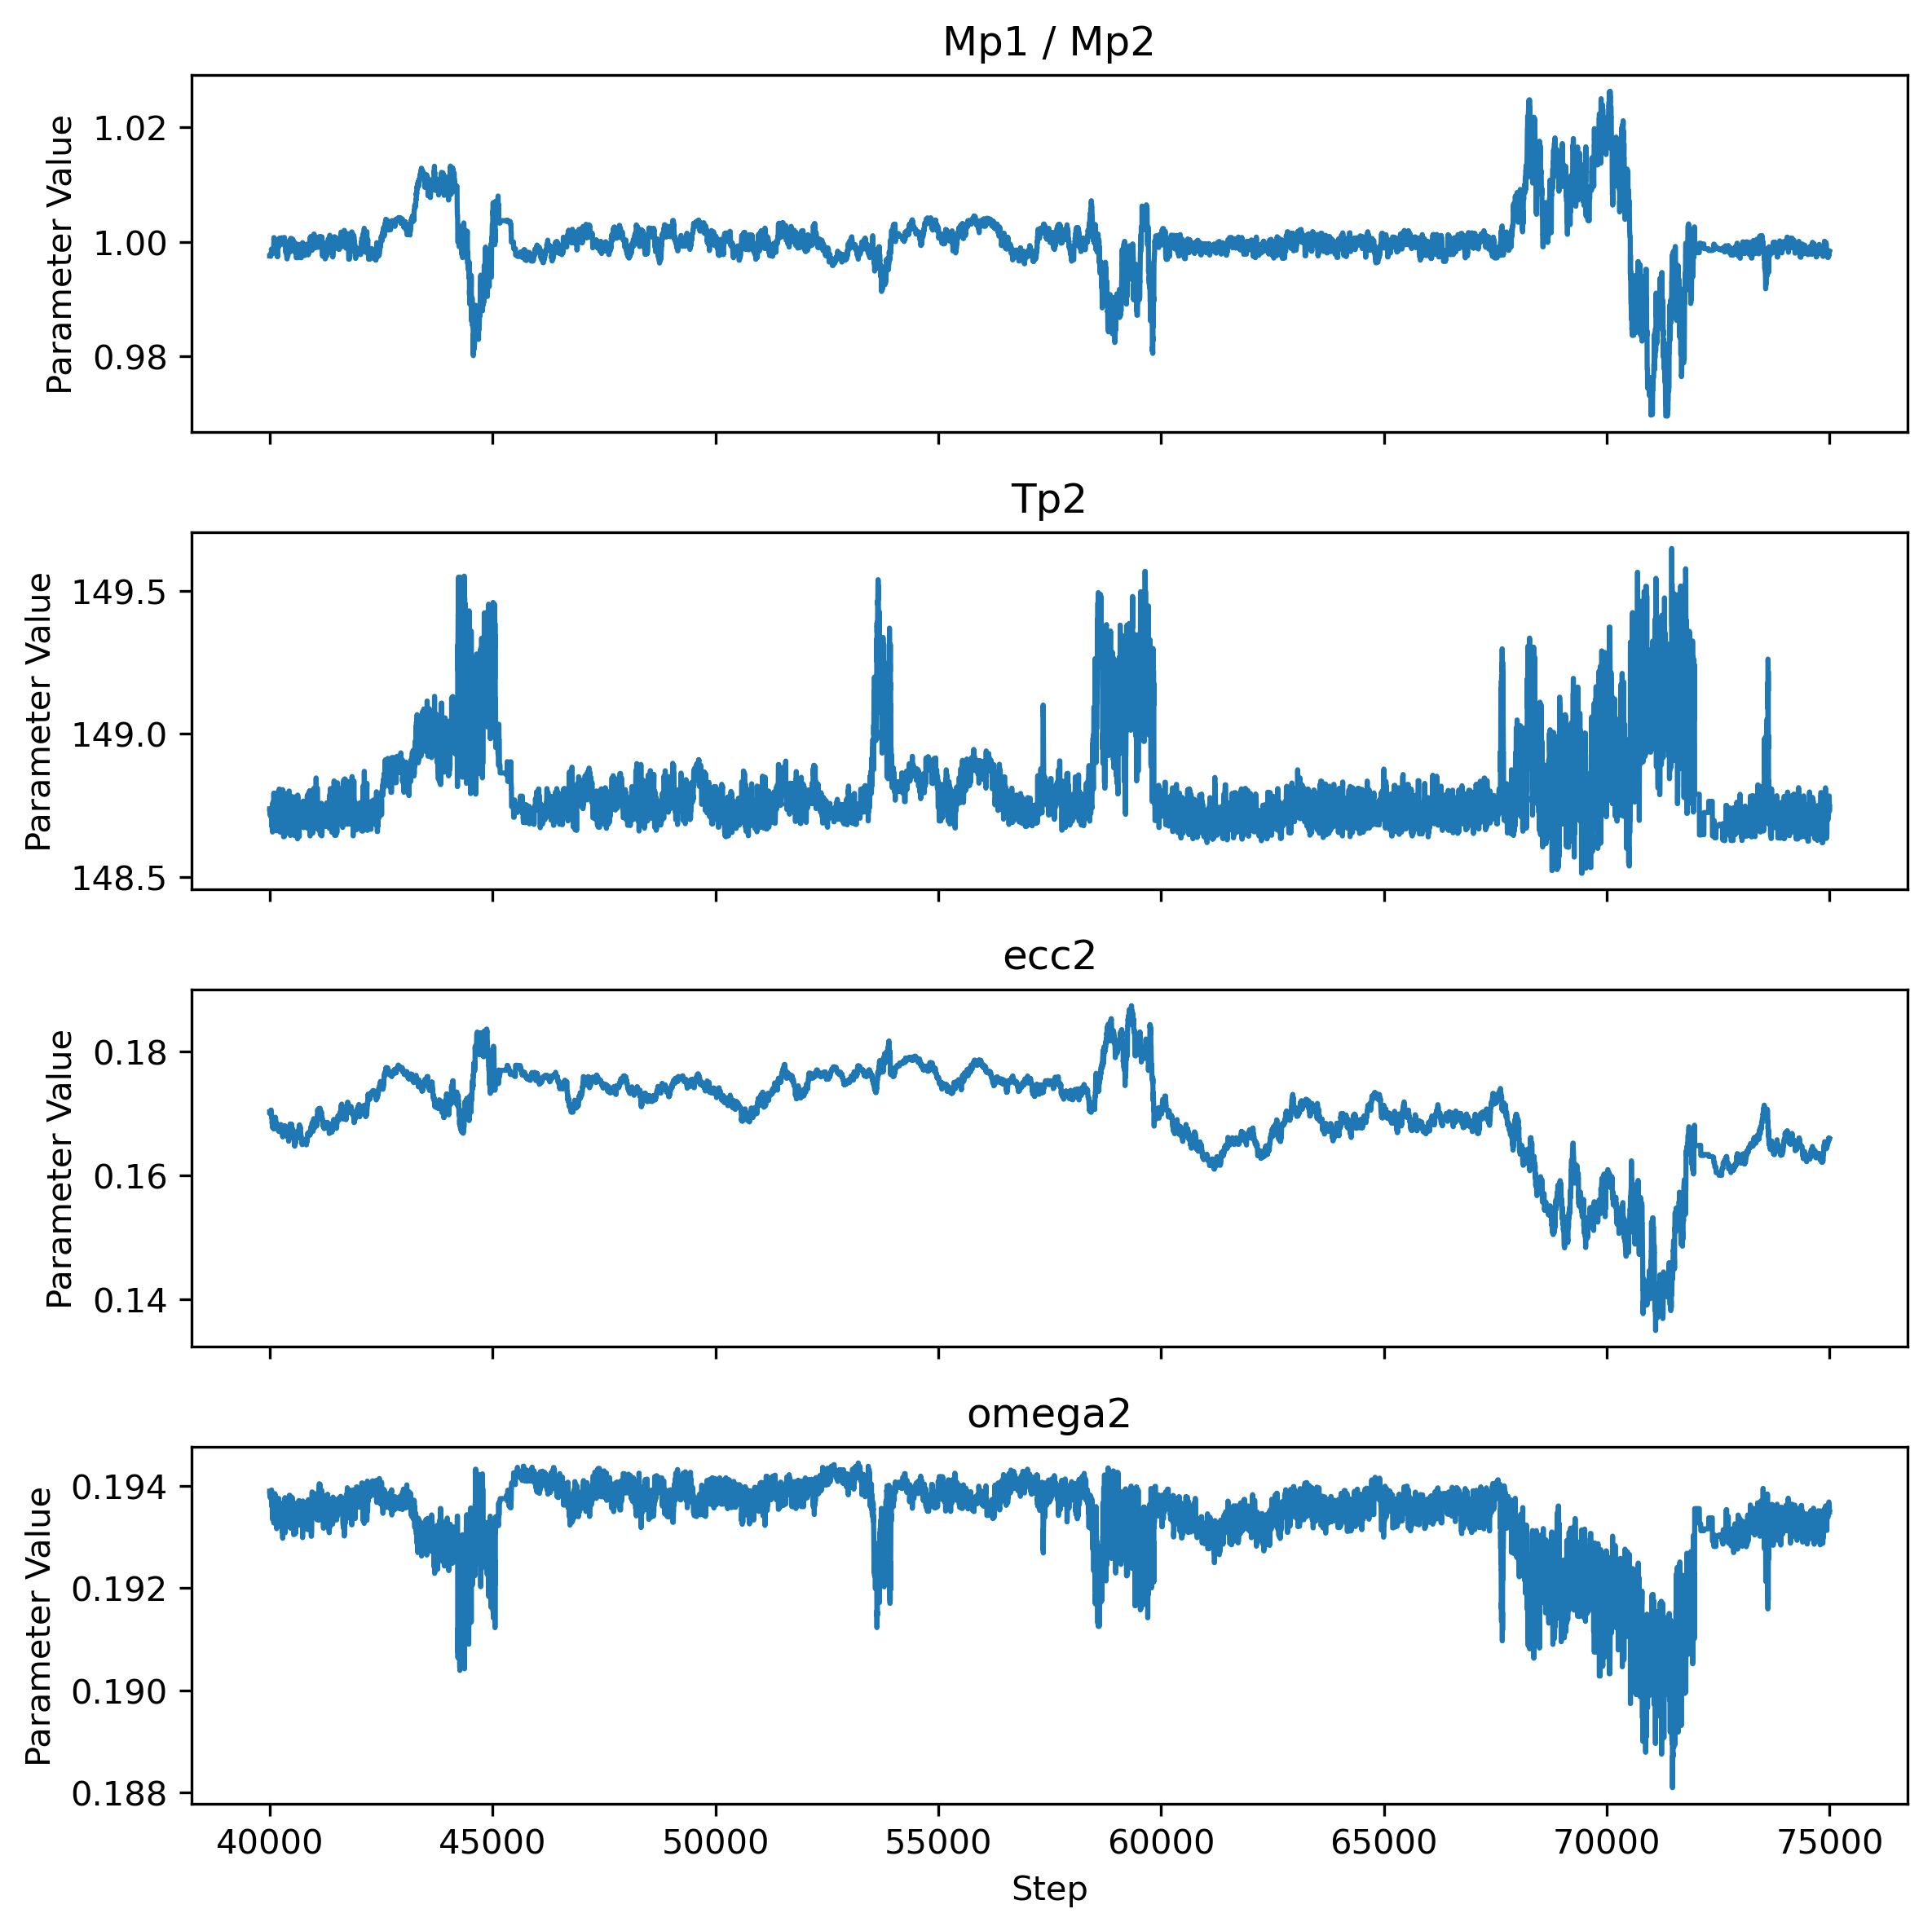

[  1.     160.       0.2      0.5236]
[  0.99977 148.76326   0.17123   0.19358]


In [32]:
steps = np.arange(0, nsamp)
steps = steps[burnin:]
# Number of parameters
n_params = len(titles)

# Create a figure and subplots stacked vertically
fig, axes = plt.subplots(n_params, 1, figsize=(8, 2 * n_params), sharex=True)

# Plot each parameter chain on its corresponding subplot
for i, ax in enumerate(axes):
    ax.plot(steps, chain[:, i])  # Plot for the i-th parameter
    ax.set_title(titles[i])
    ax.set_ylabel("Parameter Value")

# Label the x-axis only on the bottom plot
axes[-1].set_xlabel("Step")

# Adjust the layout for better spacing
plt.tight_layout()

# Show the figure
plt.show()

np.set_printoptions(precision=5, suppress=True)
print(real)
print(np.median(chain, axis=0))

Although the chains almost converge, we can see some spontaneous and correlated jumps. They may appear due to flaws in our adaptation steps implementation. By comparing median chain values to the real parameters we can conclude that the mass ratio was inferred successfully. The period of the second planet was over-shot during sampling, and the eccentricity and the argument of periapsis were getting closer to the real values. We believe that running the algorithms for more steps and including some physically backed boundaries for the parameters would improve the convergence. 


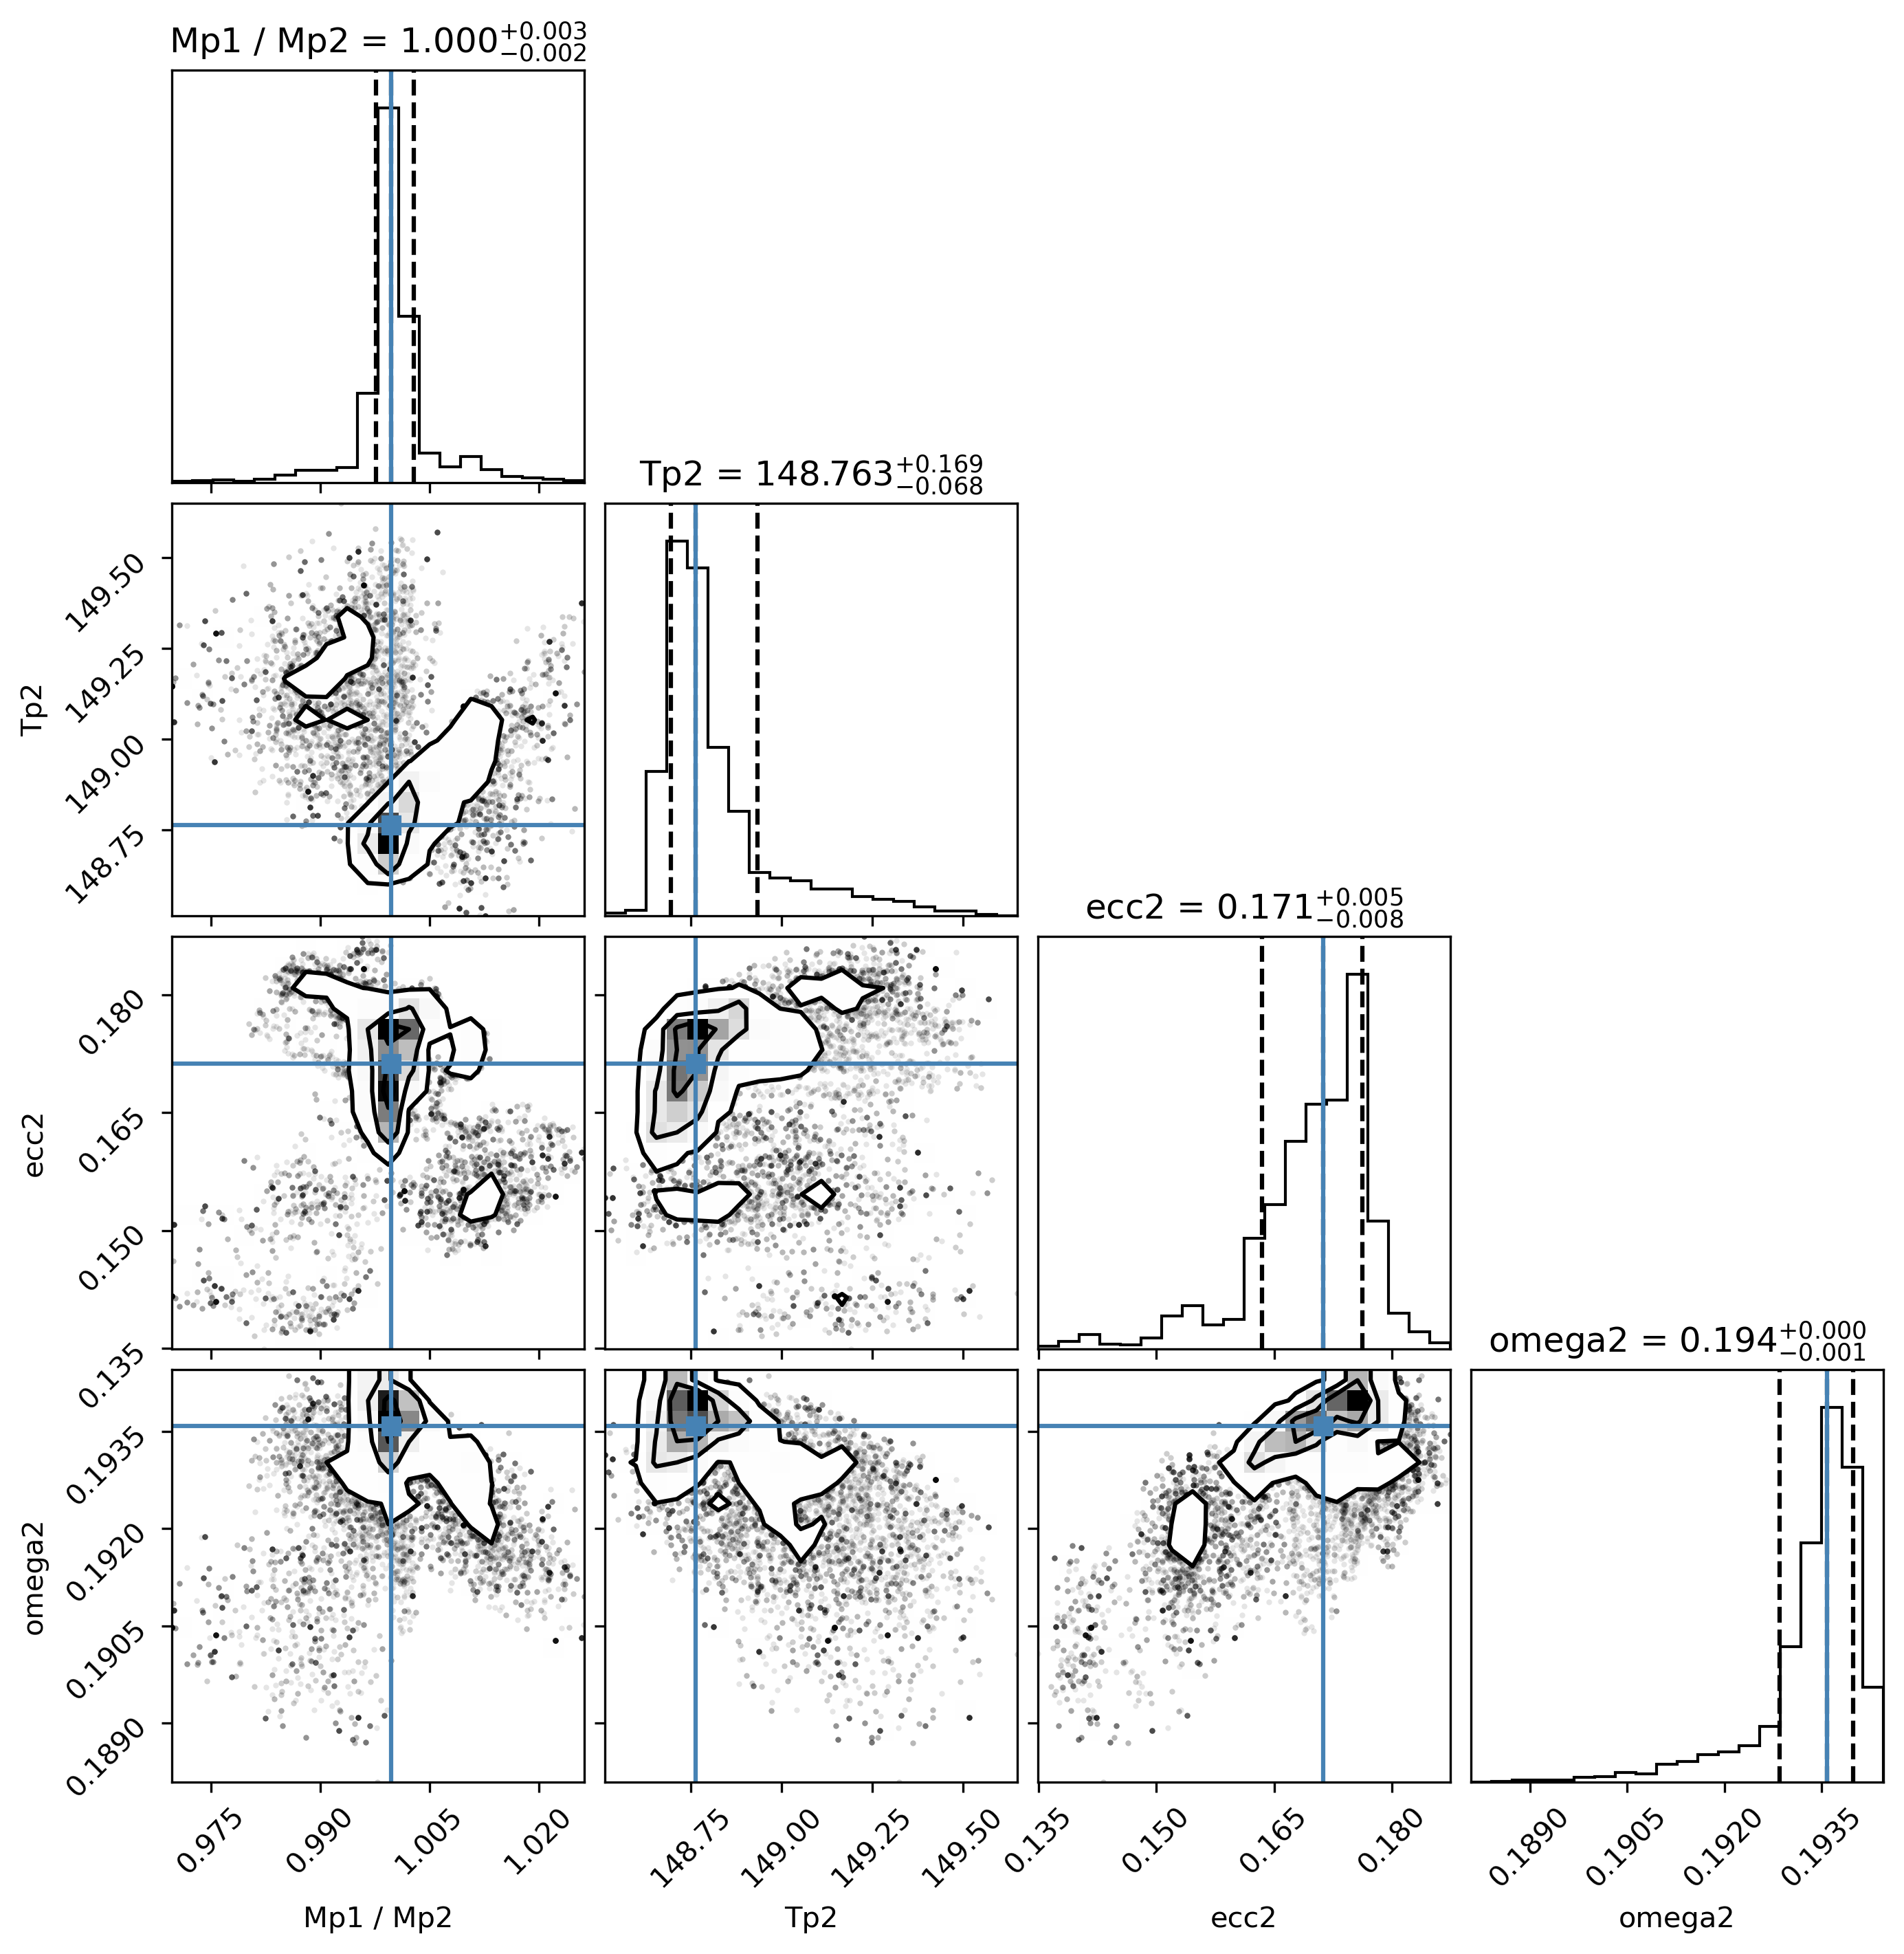

In [35]:
# Create a corner plot
fig = corner.corner(chain, labels=titles, truths=np.median(
    chain, axis=0), quantiles=[0.16, 0.5, 0.84], show_titles=True, title_fmt='.3f', )

# Show the plot
plt.show()

The mass ratio distribution behaves closely like a Gaussian. The fact that other parameters tend to lean towards one edge suggests that they could still be sampled for a longer time.


Let's now see how well could we fit the O-C curve

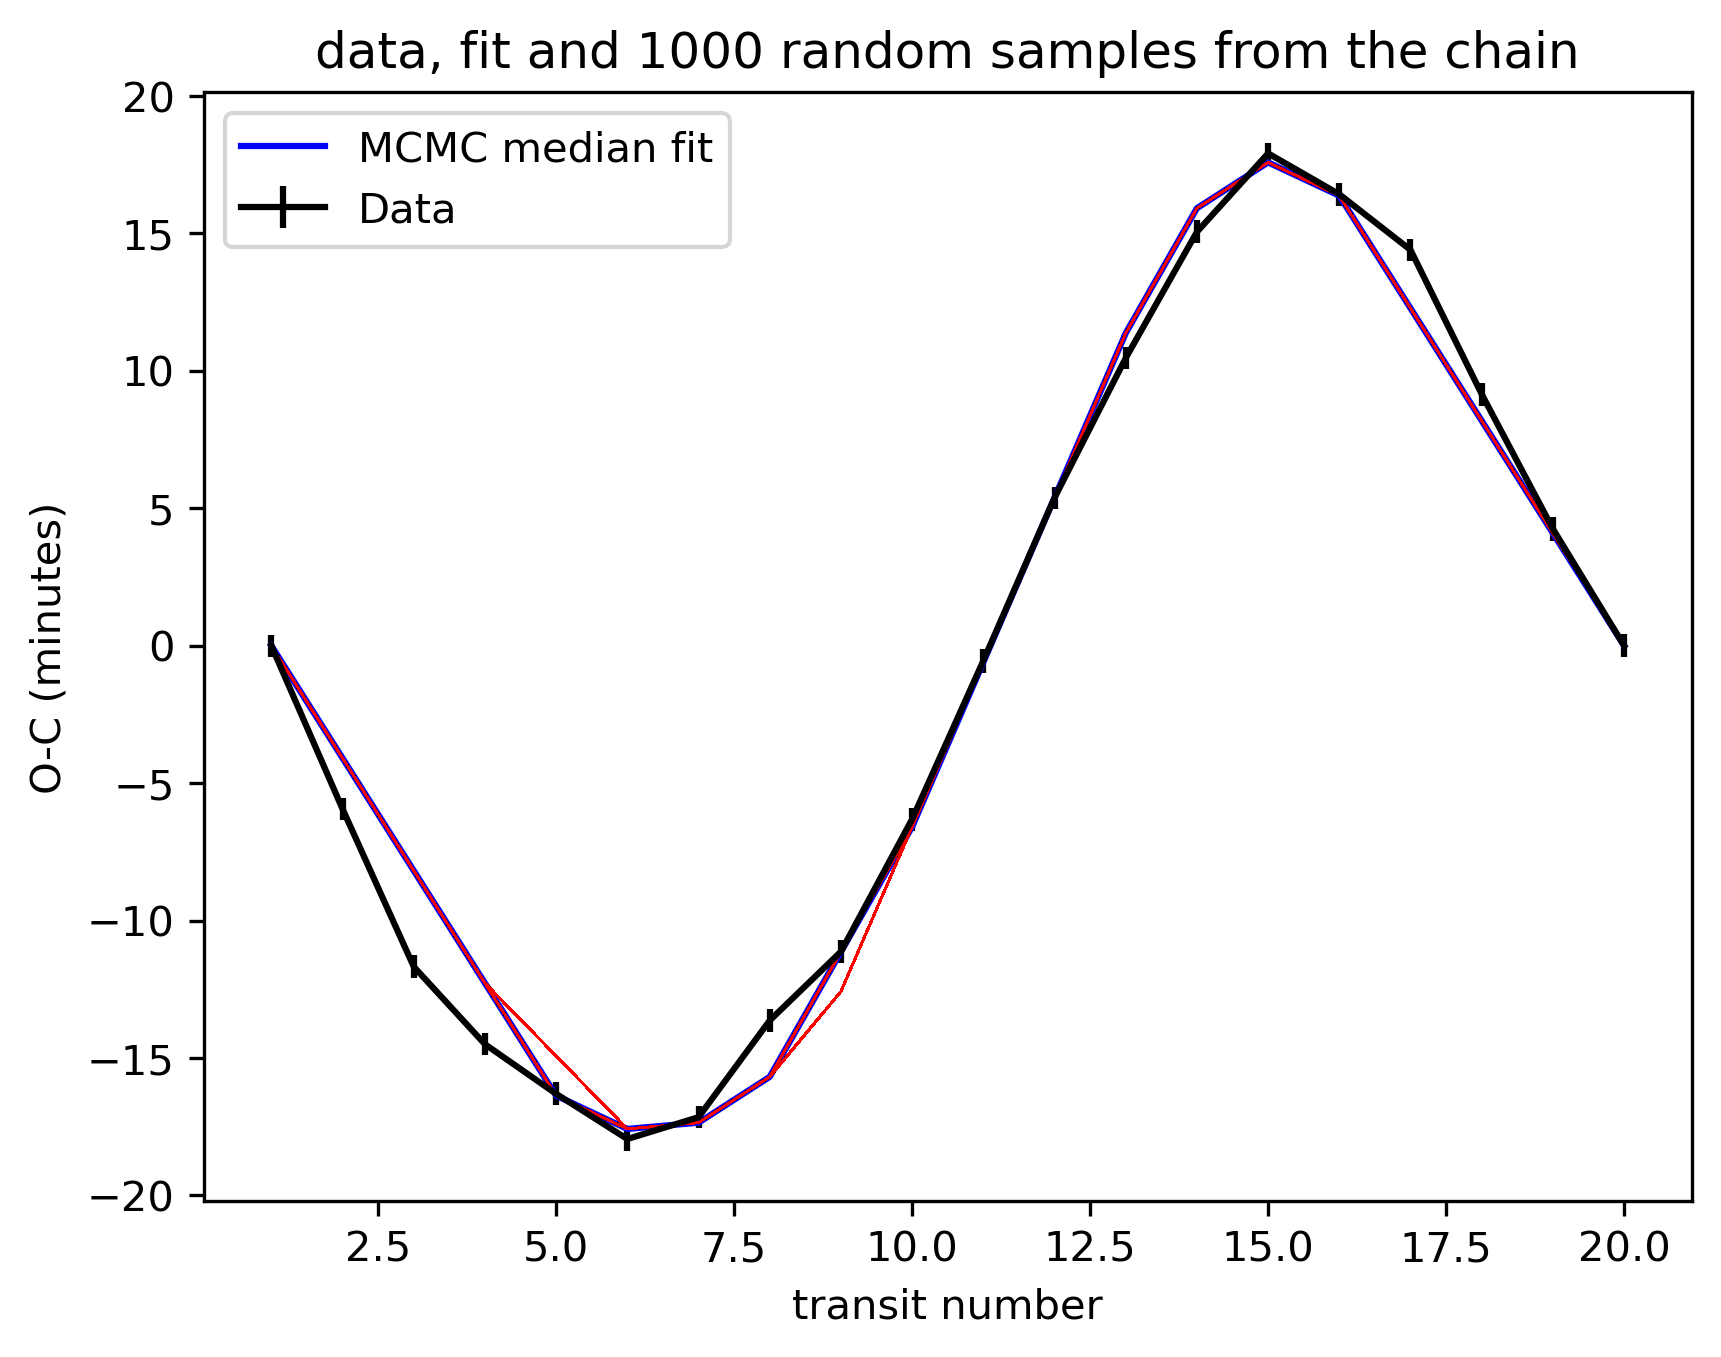

In [63]:
fit = get_oc(np.median(chain, axis=0), ts)
num_t = np.arange(1,len(data)+1)
plt.errorbar(num_t, data, errs, c='k', label='Data')
plt.plot(num_t, fit, c='blue', label='MCMC median fit')
#for _ in range(1000):
#    sample = chain[np.random.randint(len(chain))]
#    fit_sample = get_oc(sample, ts)
#    plt.plot(num_t, fit_sample, c='blue', alpha=0.3, lw=0.5)

for sample in chain[-10000:]:
    fit_sample = get_oc(sample, ts)
    plt.plot(num_t, fit_sample, c='r', alpha=0.3, lw=0.5)
plt.xlabel("transit number")
plt.ylabel("O-C (minutes)")
plt.title('data, fit and 1000 random samples from the chain')
plt.legend()
plt.show()

In [72]:
chi_sq = np.sum((data - fit)**2/errs**2)
print('chisq: ',chi_sq)

chisq:  190.0825672236995


1000 last samples from the chain don't seem to deviate a lot from the resulting O-C curve, yet none get close to or overlap the first few data points. 



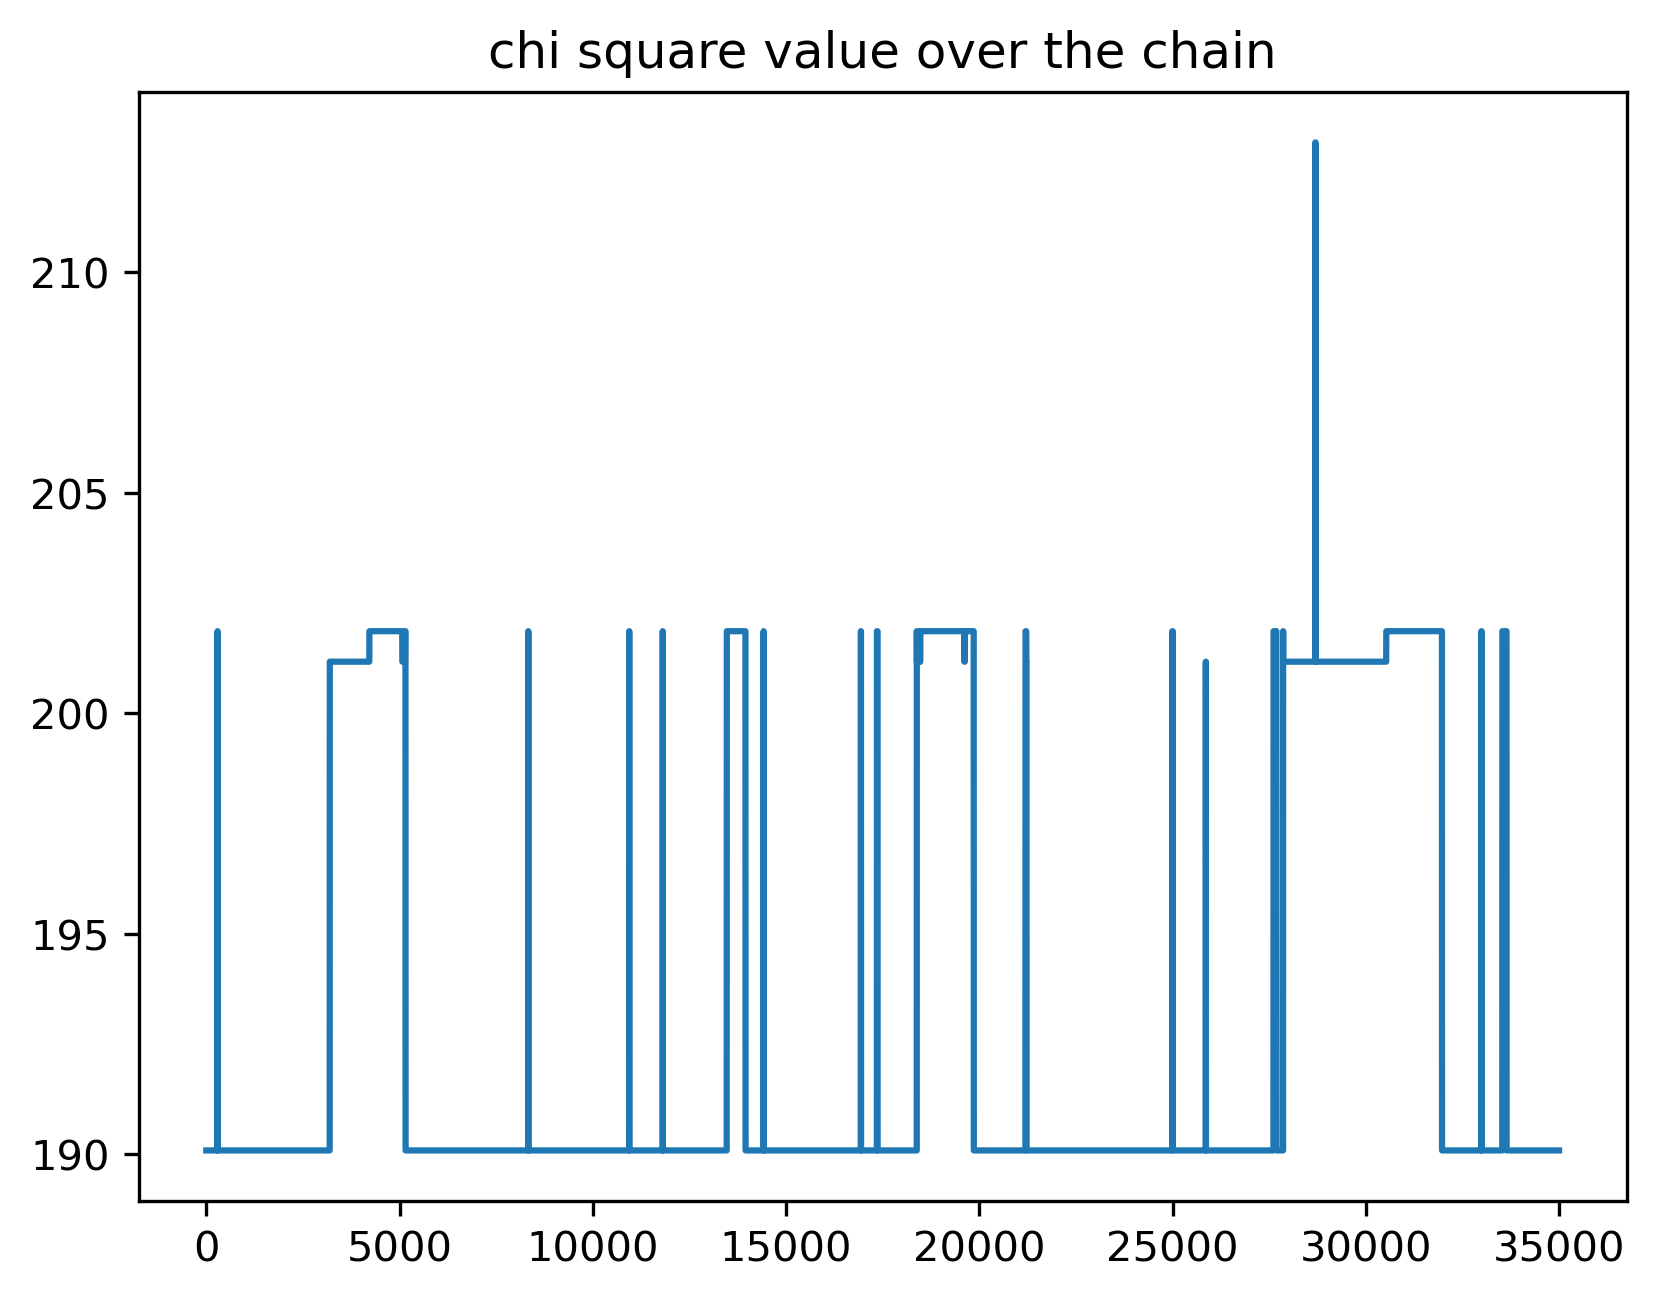

In [75]:
plt.plot(chivec)
plt.title('chi square value over the chain')
plt.show()

Chi-square doesn't change, which means we are pretty stagnating at this point. The likely issue is our step size, which in turn is the issue of our adaptive step implementation. So, in general, the method works fine but could go long with minor improvements. 

A side note: we did not incorporate errors on the mid-transit point from the N-body simulation which in theory should be as twice as large as the error from the MCMC results from Part II

